<a href="https://colab.research.google.com/github/harrisb002/CS_479/blob/Labs/thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thresholding

When performing logical operations of the type ```image > value``` we have seen that this allowed us to perform **thresholding**, one the basic image processing methods to identify objects in an image. Here we come back to this topic and show how we can automated the threshold selection, combine masks etc.

Some of the content in this notebook is taken from the image processing course by [Guillaume Witz](https://github.com/guiwitz).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
from skimage import data
import math

## Importing the image

Let's import the image, plot it and check its dimensions:

In [ ]:
image_stack = skimage.io.imread('46658_784_B12_1.tif')

In [ ]:
image_stack.shape

(2048, 2048, 3)

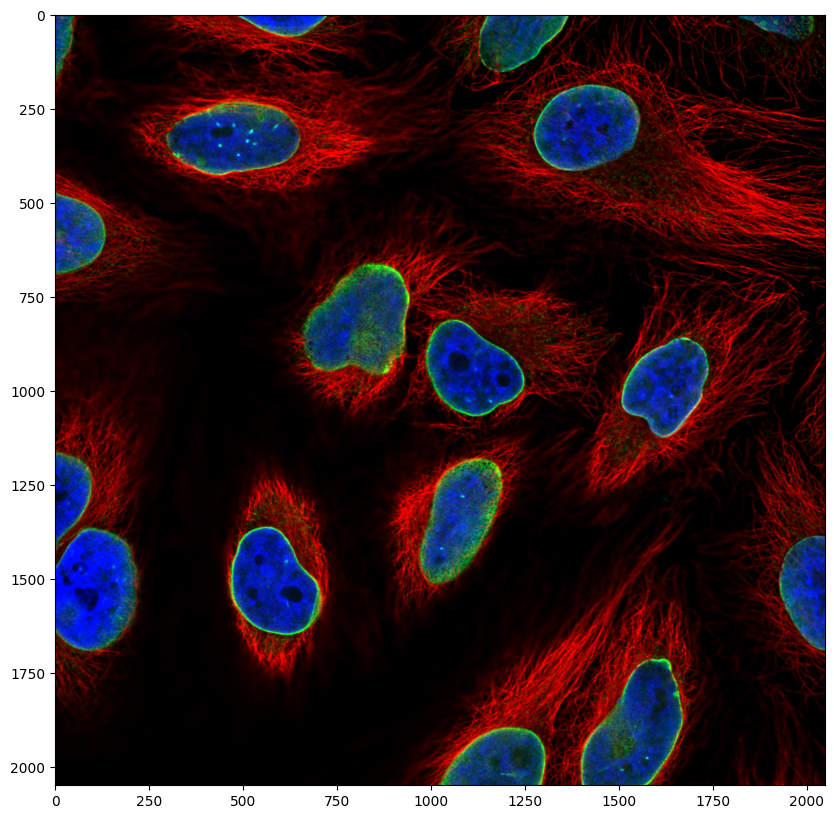

In [ ]:
plt.subplots(figsize=(10,10))
plt.imshow(image_stack);

We have again a three channel image, i.e. our image is composed of three planes. For the moment we only want to work with the nuclei, so we isolate that channel, the third one:

In [ ]:
image_nuclei = image_stack[:,:,2]

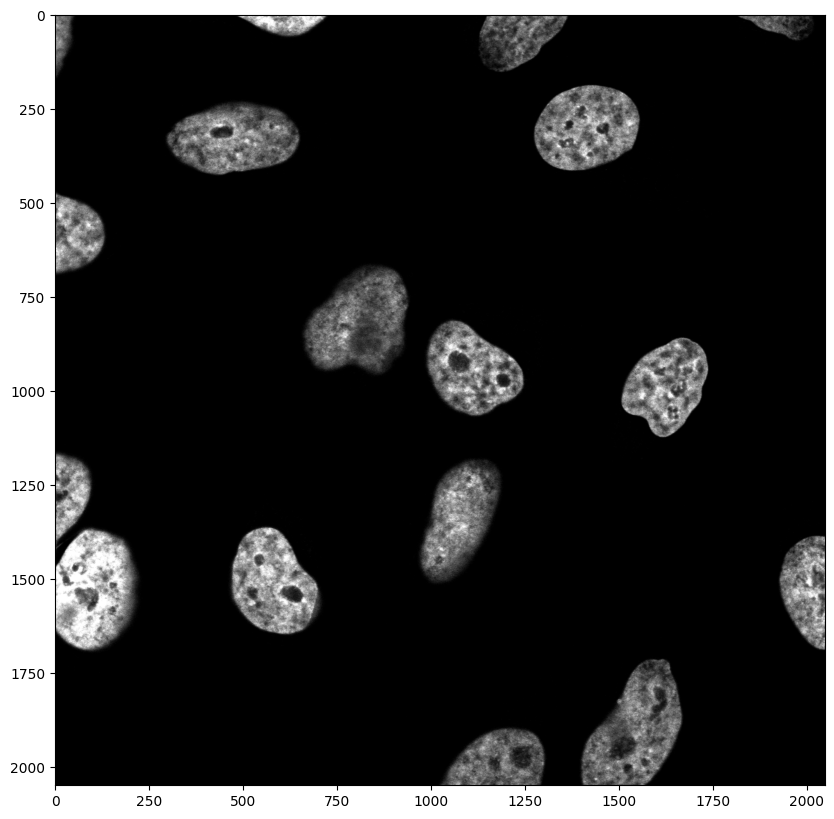

In [ ]:
plt.subplots(figsize=(10,10))
plt.imshow(image_nuclei, cmap = 'gray');

## Manual investigation

If we want to isolate nuclei, we have to know more or less what intensity they have so that we can use a cutoff value on pixel intensities. We can use the histogram of pixel values to figure out that cutoff value!

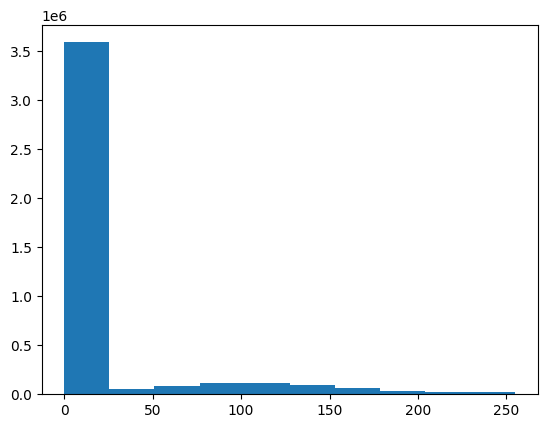

In [ ]:
plt.hist(np.ravel(image_nuclei));

Clearly we have background intensity between 0 and ~50, and the signal spread out between 50 and 255. We can create a mask of all the pixels with a value above 50:

In [ ]:
mask = image_nuclei > 50

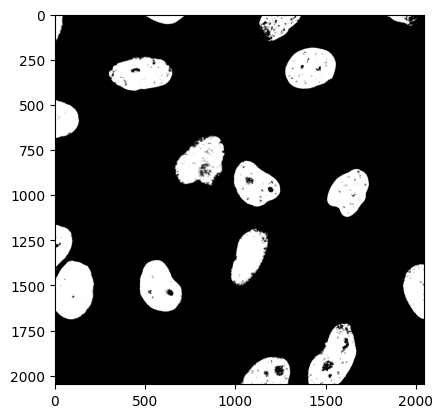

In [ ]:
plt.imshow(mask, cmap = 'gray');

For the sake of the experiment, let's use a higher threshold:

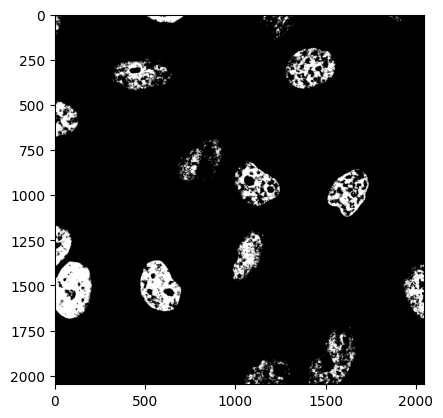

In [ ]:
mask = image_nuclei > 120
plt.imshow(mask, cmap = 'gray');

Clearly, if the threshold is too high, we loose important parts of the image.

## Automatic thresholding

Setting a threshold manually is not ideal for two reasons:
1. your eyes might fool you
2. if you have to do this operation on 100s of images you don't want to do it by hand.

Several methods have been developed to detect an "ideal" threshold based on the pixel histogram. One of the most famous ones is the Otsu method: it sets a threshold by dividing the pixels in two classes and tries to minimize the variance of both classes.

Such classical algorithms are all implemented in scikit-image and we can just use them out of the box. All algorithm are grouped in logical groups (filtering, measuring etc.) Often the easiest is just to use Google to find them.

For example the [Otsu algorithm](https://www.google.com/search?q=skimage+otsu&oq=skimage+otsu&aqs=chrome..69i57j69i60j0l4.2268j0j7&sourceid=chrome&ie=UTF-8):

In [ ]:
import skimage.filters

help(skimage.filters.threshold_otsu)

Help on function threshold_otsu in module skimage.filters.thresholding:

threshold_otsu(image=None, nbins=256, *, hist=None)
    Return threshold value based on Otsu's method.
    
    Either image or hist must be provided. If hist is provided, the actual
    histogram of the image is ignored.
    
    Parameters
    ----------
    image : (N, M[, ..., P]) ndarray, optional
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    hist : array, or 2-tuple of arrays, optional
        Histogram from which to determine the threshold, and optionally a
        corresponding array of bin center intensities. If no hist provided,
        this function will compute it from the image.
    
    
    Returns
    -------
    threshold : float
        Upper threshold value. All pixels with an intensity higher than
        this value are assumed to be foreground.
    
    References
    ----------

In [ ]:
my_otsu_threshold = skimage.filters.threshold_otsu(image_nuclei)
print(my_otsu_threshold)

66


Using that value we can create a new mask:

In [ ]:
mask_nuclei = image_nuclei > my_otsu_threshold

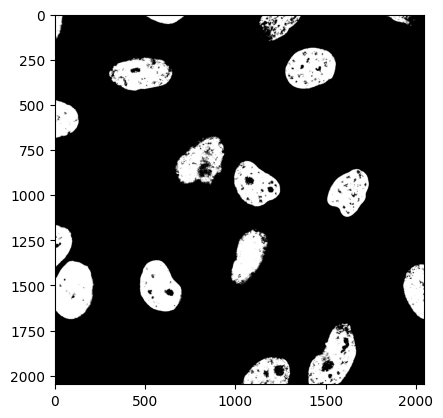

In [ ]:
plt.imshow(mask_nuclei, cmap = 'gray');

## Combining masks

We can do the same thresholding operation on the other channel contained in the image. Let's first "isolate" the first channel (red):

In [ ]:
image_cells = image_stack[:,:,0]

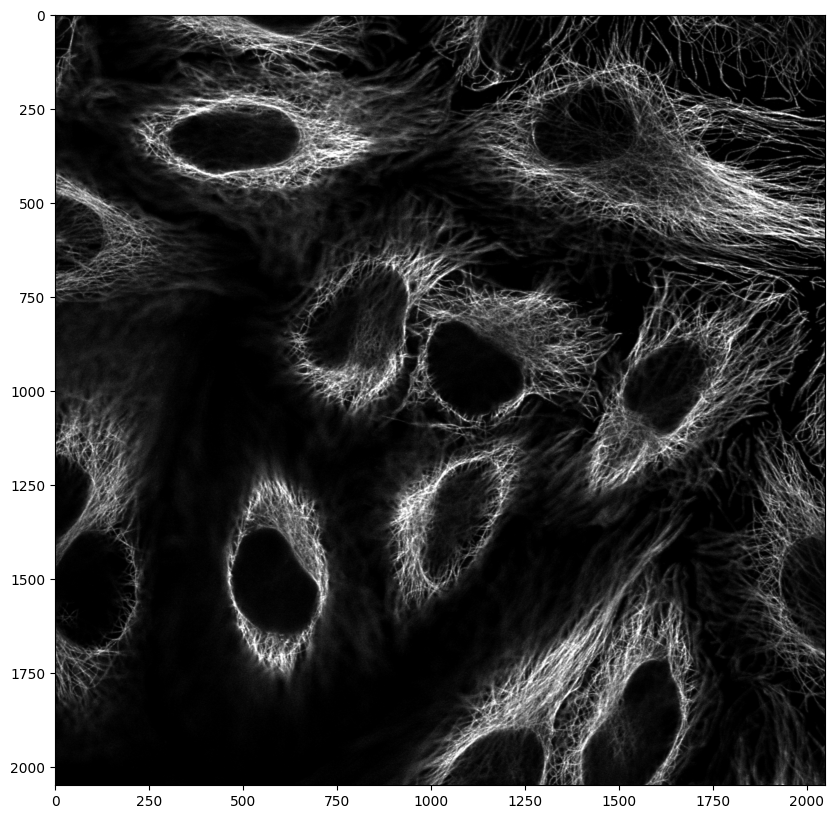

In [ ]:
plt.subplots(figsize=(10,10))
plt.imshow(image_cells, cmap = 'gray');

In [ ]:
mask_cells = image_cells > skimage.filters.threshold_otsu(image_cells)

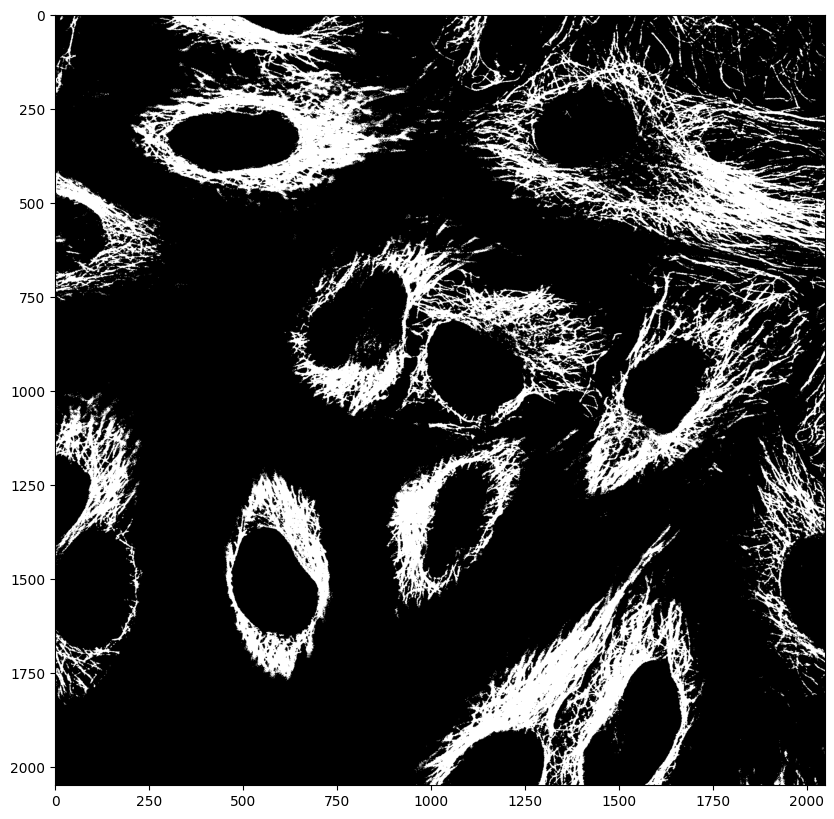

In [ ]:
plt.subplots(figsize=(10,10))
plt.imshow(mask_cells, cmap = 'gray');

We can in principle combine masks however we want. For example we can consider pixels that are ON (```True```) in both masks by multiplying them as only ```True x True = True```

In [ ]:
both_masks = mask_cells * mask_nuclei

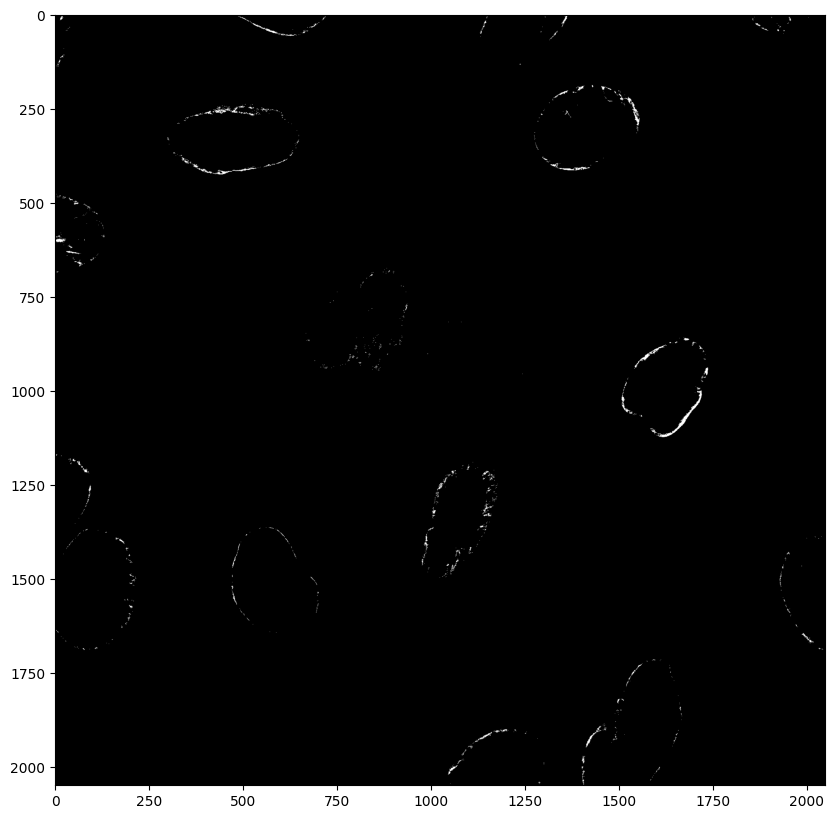

In [ ]:
plt.subplots(figsize=(10,10))
plt.imshow(both_masks, cmap = 'gray');

or we can consider pixels that are ON (```True```) in one **or** the other image by adding them as ```True + False = True```:

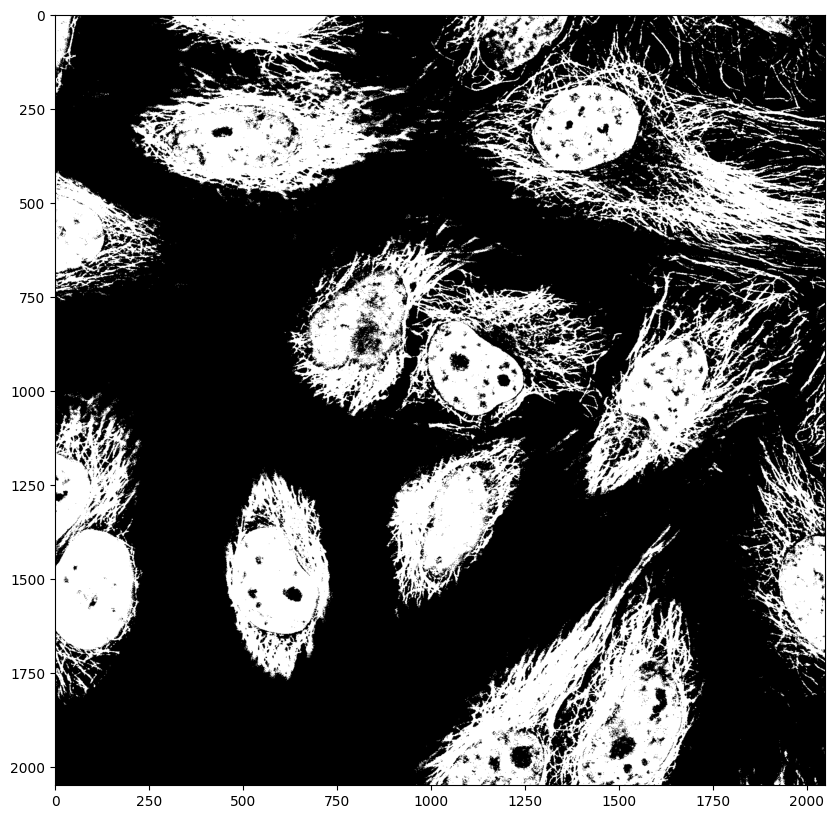

In [ ]:
plt.subplots(figsize=(10,10))
plt.imshow(mask_cells + mask_nuclei, cmap = 'gray');

To make things cleaner, instead of just using operators such as ```+``` or ```*``` we can be more explicit and use logical Numpy operations such as ```np.logical_or()```:

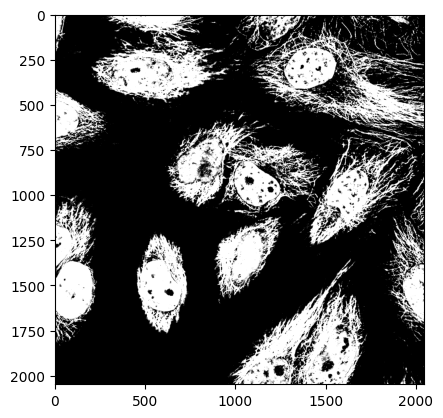

In [ ]:
combine_or = np.logical_or(mask_cells, mask_nuclei)
plt.imshow(combine_or, cmap = 'gray');

This has **segmented** elements in our image. In future labs, we will improve the masks by cleaning them up using binary/morphological operations. We will also quantify those elements.

## Other ways to automatically find the threshold

Choosing a threshold is important and can impact what is preserved or lost in the image.
A naive way to automate this process would be by using the mean value of pixel intensities.
This can be computed using the function `threshold_mean` in `skimage.filters`.


Threshold using mean value of pixel intensities =  129.06072616577148


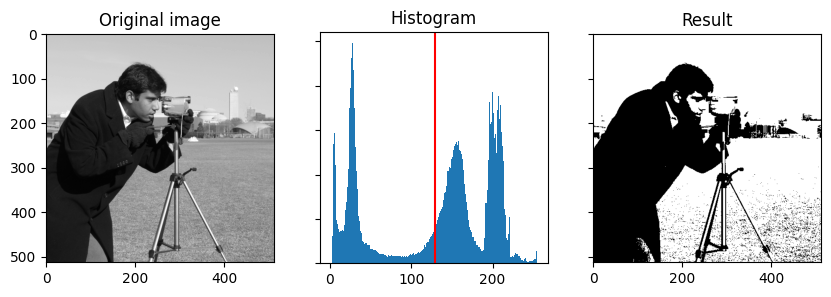

In [ ]:
from skimage.filters import threshold_mean


image = data.camera()
thresh = threshold_mean(image)
print("Threshold using mean value of pixel intensities = ", thresh)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('Result')

for a in ax:
    a.label_outer()

plt.show()

Bimodal histogram
=================

For pictures with a bimodal histogram, more specific algorithms can be used.
For instance, the `minimum` algorithm takes a histogram of the image and smooths it
repeatedly until there are only two peaks in the histogram.
This can be implemented using the function `threshold_minimum` in `skimage.filters`.



In [ ]:
help(skimage.filters.threshold_minimum)

Help on function threshold_minimum in module skimage.filters.thresholding:

threshold_minimum(image=None, nbins=256, max_num_iter=10000, *, hist=None)
    Return threshold value based on minimum method.
    
    The histogram of the input ``image`` is computed if not provided and
    smoothed until there are only two maxima. Then the minimum in between is
    the threshold value.
    
    Either image or hist must be provided. In case hist is given, the actual
    histogram of the image is ignored.
    
    Parameters
    ----------
    image : (N, M[, ..., P]) ndarray, optional
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    max_num_iter : int, optional
        Maximum number of iterations to smooth the histogram.
    hist : array, or 2-tuple of arrays, optional
        Histogram to determine the threshold from and a corresponding array
        of bin center intensities. 

Threshold using an algorithm threshold_minimum =  85


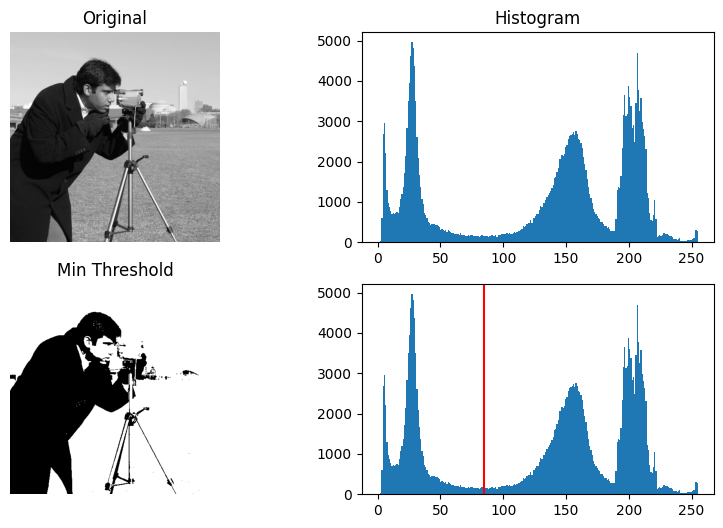

In [ ]:
from skimage.filters import threshold_minimum


image = data.camera()

thresh_min = threshold_minimum(image)
print("Threshold using an algorithm threshold_minimum = ", thresh_min)

binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap='gray')
ax[1, 0].set_title('Min Threshold')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

# Part A (30 points)
This section has several sub-parts. Some sub-parts have a DEMO component.

Import the image `13585.tif` and store it in variable `image_stack`

In [ ]:
# YOUR CODE HERE
image_stack = skimage.io.imread('13585.tif')

## Part A1
**(DEMO)** Display the image along with its 3 color channels in a `2 x 2` grid in the coding cell below.

There is something strange about one of the channels. Can you identify which one?

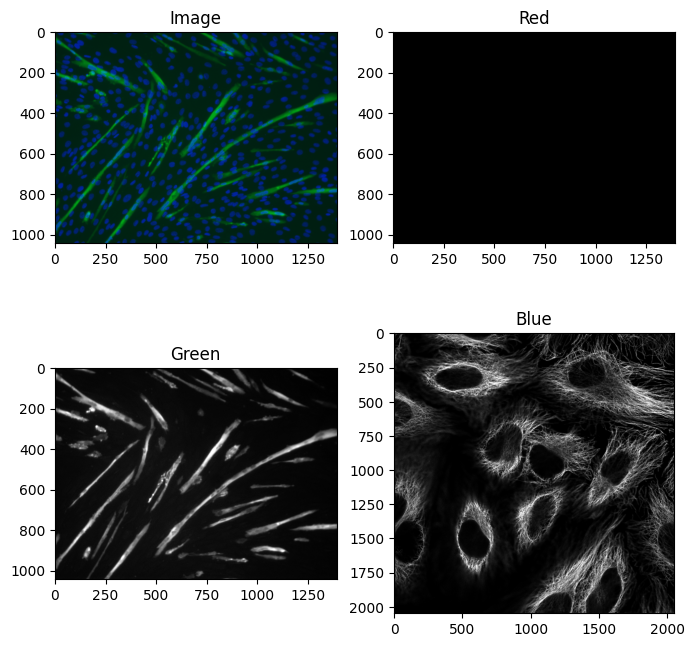

In [ ]:
# YOUR CODE HERE
image_cells_red = image_stack[:,:,0]
image_cells_green = image_stack[:,:,1]
image_cells_blue = image_stack[:,:,2]

fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].imshow(image_stack, cmap='gray')
ax[0,0].set_title('Image')

ax[0,1].imshow(image_cells_red, cmap='gray')
ax[0,1].set_title('Red')

ax[1,0].imshow(image_cells_green, cmap='gray')
ax[1,0].set_title('Green')

ax[1,1].imshow(image_cells_blue, cmap='gray')
ax[1,1].set_title('Blue')

plt.imshow(image_cells, cmap = 'gray');

Create a new variable called ```image_green``` that contains only the green channel by slicing the array
 and a new variable called ```image_blue``` that contains only the blue channel by slicing the array

In [ ]:
# YOUR CODE HERE
image_green = image_stack[:,:,1]
image_blue = image_stack[:,:,2]

Plot a histogram of ```image_green``` using 64 bins and store the **frequency** in a variable `n` and edges of the bins in a variable `bins`.

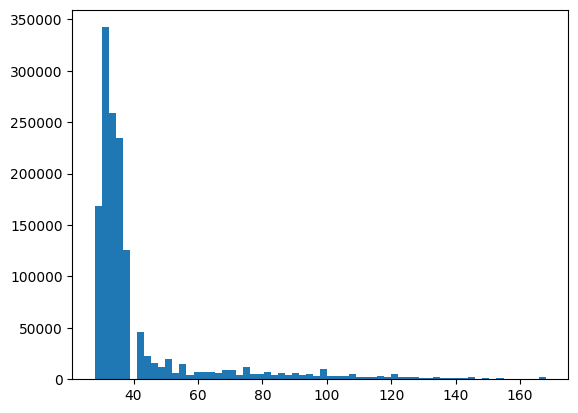

In [ ]:
# YOUR CODE HERE
n, bins, _ = plt.hist(image_green.ravel(), bins=64)

In [ ]:
print(n[4], n[5], bins[4], bins[5])
assert(len(n) == 64)
assert(n[4] == 125311.0)
assert(n[5] == 553.0)
print("All tests passsed")

125311.0 553.0 36.75 38.9375
All tests passsed


Note that there is a huge drop in frequency between `n[4]` and `n[5]`. What is the integer **bin value** between these two frequencies? That could be a first threshold we can try to recover the large structures in ```image_green```! Find that threshold (store in variable `thresh_manual`), and create the corresponding binary mask (store in variable `binary_manual`).

**Hint**: There are two integers that satisfy the integer requirement. Use the larger of the two as the threshold.

In [ ]:
# YOUR CODE HERE
thresh_manual = 39
binary_manual = image_green > thresh_manual

In [ ]:
print(np.mean(binary_manual))
assert(math.isclose (np.mean(binary_manual), 0.2199678105))

0.21996781056587092


Write a function that, given the image, a threshold, and a mask, outputs three plots: the input image, histogram overlaid with the threshold, and the mask image

In [ ]:
def plotImgHistMask(image, thresh, binary):
    '''
    Plots the input image, the histogram of the image
    and the binary image in a single row.

    Overlays the histogram with a vertical red line given by the threshold thresh
    '''
    # YOUR CODE HERE

    #Create plots
    fig, axes = plt.subplots(ncols=3, figsize=(15, 3))
    ax = axes.ravel()

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Input Image')

    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title('Mask Image')

    # Histogram with overlayed threshold
    # Create a list of arrays to store pixel values for each image
    ax[2].hist(image.ravel(), 24, density=True, histtype='bar', color="Blue")

    #Threshold overlaid
    ax[2].axvline(thresh, color='r')

    ax[2].set_title('Histogram with threshold')
    ax[2].set_ylabel('Frequency')
    ax[2].set_xlabel('Range of Pixels')

    plt.show()


## Part A2
**(DEMO)** Plot the binary image obtained using `thresh_manual` by using the following function call in the coding cell below:

`plotImgHistMask(image_green, thresh_manual, binary_manual)`

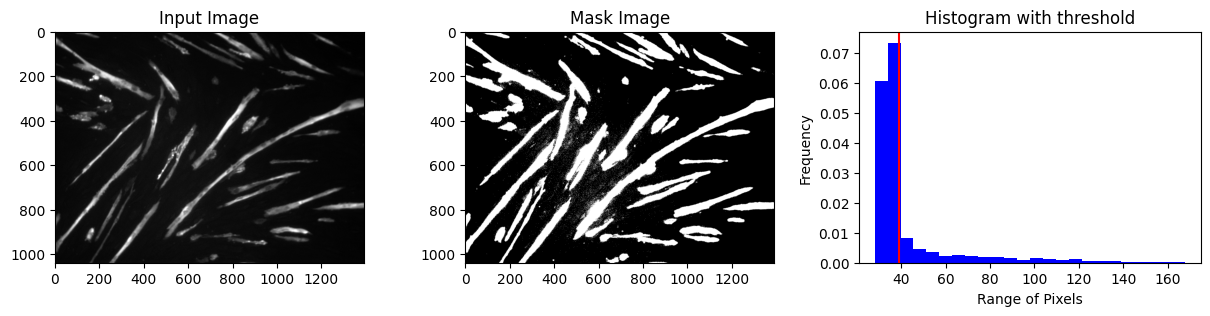

In [ ]:
# YOUR CODE HERE
plotImgHistMask(image_green, thresh_manual, binary_manual)

Now, find the threshold using `otsu` method, and return a tuple comprising threshold and binary image obtained by applying the threshold

In [ ]:
def otsuThreshImage(image):
    '''
    Finds optimal threshold using the otsu method.
    Returns the threshold and the binary image in a tuple
    '''
    # YOUR CODE HERE
    threshold = skimage.filters.threshold_otsu(image)
    binary_image = image > skimage.filters.threshold_otsu(image)
    return (threshold,binary_image)

In [ ]:
thresh_green_otsu, binary_green_otsu = otsuThreshImage(image_green)
thresh_green_mean = threshold_mean(image_green)

assert(math.isclose(thresh_green_mean, 42.063812444))
assert(thresh_green_otsu == 66)
assert(math.isclose (np.mean(binary_green_otsu), 0.102361019))
assert(math.isclose (np.std(binary_green_otsu), 0.3031224848))

## Part A3
**(DEMO)** Plot the binary image obtained using `thresh_green_otsu` by using the following function call in the coding cell below:

`plotImgHistMask(image_green, thresh_green_otsu, binary_green_otsu)`

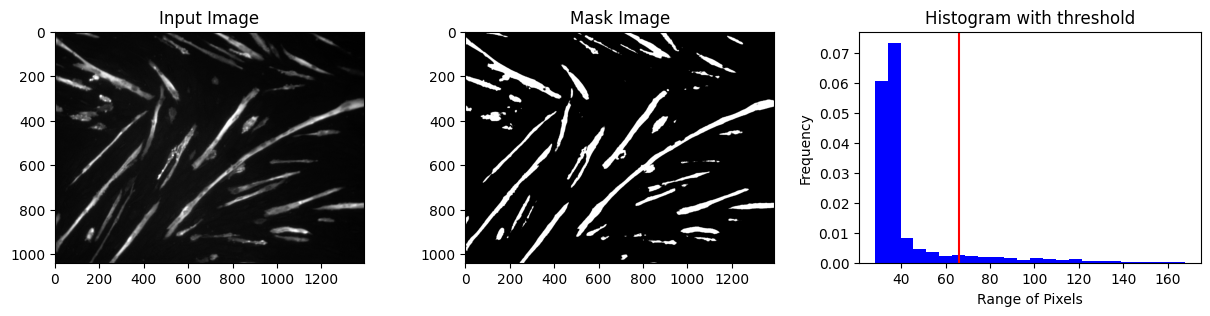

In [ ]:
# YOUR CODE HERE
plotImgHistMask(image_green, thresh_green_otsu, binary_green_otsu)

## Part A4
**(DEMO)** Plot the binary image obtained after applying the threshold obtained from the `threshold_mean` algorithm on `image_green`. Write the function call yourself this time in the coding cell below.

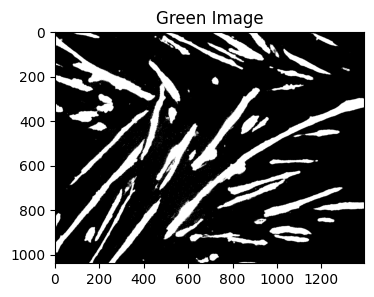

In [ ]:
# YOUR CODE HERE
def mean_thresh(img):
    thresh = threshold_mean(img)
    binary = img > thresh

    fig, ax = plt.subplots(figsize=(10, 3))

    ax.imshow(binary, cmap='gray')
    ax.set_title('Green Image')

mean_thresh(image_green)

Let us repeat some of these steps on the **blue channel** (previously stored in variable `image_blue`)

In [ ]:
thresh_blue_otsu, binary_blue_otsu = otsuThreshImage(image_blue)
thresh_blue_min = threshold_minimum(image_blue)

assert(math.isclose(thresh_blue_min, 65))
assert(thresh_blue_otsu == 67)
assert(math.isclose (np.mean(binary_blue_otsu), 0.2153259007))
assert(math.isclose (np.std(binary_blue_otsu), 0.4110482419))


## Part A5
**(DEMO ONLY)** Plot the binary image obtained after applying the threshold `thresh_blue_otsu` on `image_blue` using the following function call in the coding cell below:

`plotImgHistMask(image_blue, thresh_blue_otsu, binary_blue_otsu)`

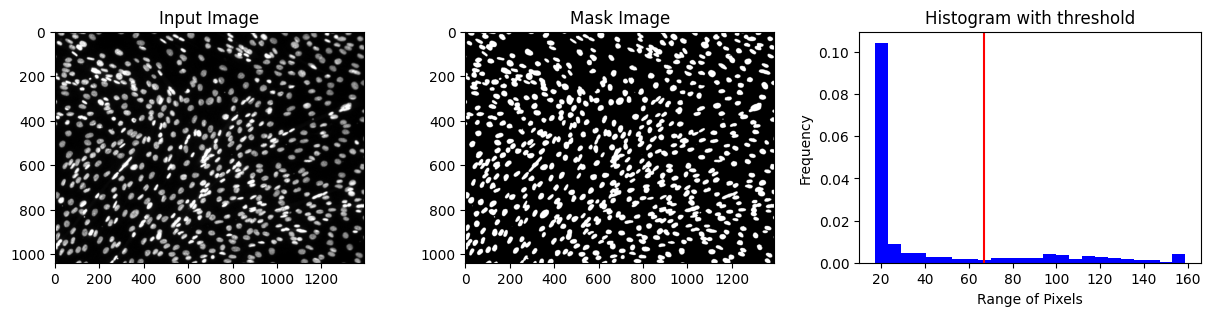

In [ ]:
# YOUR CODE HERE
plotImgHistMask(image_blue, thresh_blue_otsu, binary_blue_otsu)

## Part A6

**(DEMO)** Plot the binary image obtained after applying the threshold obtained from the `threshold_min` algorithm on `image_blue`. Write the function call yourself this time in the coding cell below.

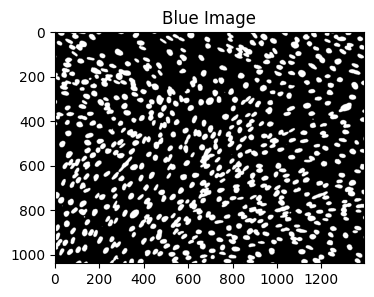

In [ ]:
# YOUR CODE HERE
def plot_image_blue(img):
    thresh = threshold_minimum(img)
    binary = img > thresh

    fig, ax = plt.subplots(figsize=(10, 3))

    ax.imshow(binary, cmap='gray')
    ax.set_title('Blue Image')

plot_image_blue(image_blue)

## Part A7: Final output

Text(0.5, 1.0, 'Segmented objects in the image')

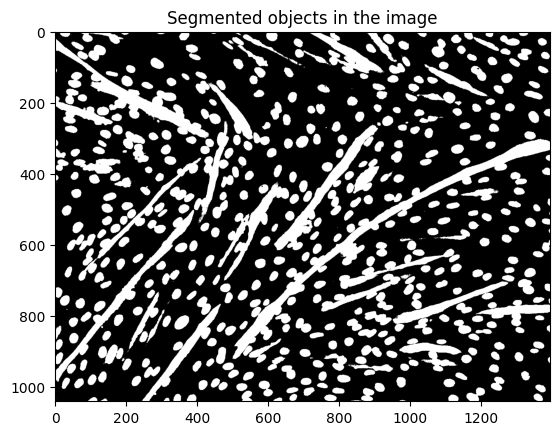

In [ ]:
output_result = binary_green_otsu + binary_blue_otsu
plt.imshow(output_result, cmap = 'gray')
plt.title("Segmented objects in the image")

In [ ]:
assert(np.sum(output_result) == 413846)

## Conclusion

As we have seen, thresholding is used to create a binary image from a grayscale image. It is the simplest way to segment objects from a background.

Thresholding algorithms implemented in scikit-image can be separated in two
categories:

- Histogram-based. The histogram of the pixels' intensity is used and
  certain assumptions are made on the properties of this histogram (e.g. bimodal).
- Local. To process a pixel, only the neighboring pixels are used.
  These algorithms often require more computation time.
  
 We have covered the first category in this lab; future lab will look into methods from the second category.

